In [1]:
!gcloud auth application-default login

Your browser has been opened to visit:

    https://accounts.google.com/o/oauth2/auth?response_type=code&client_id=764086051850-6qr4p6gpi6hn506pt8ejuq83di341hur.apps.googleusercontent.com&redirect_uri=http%3A%2F%2Flocalhost%3A8085%2F&scope=openid+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fuserinfo.email+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fcloud-platform+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fsqlservice.login&state=ntULV1kn3HRx3YYkifkHgDdJBzNb9j&access_type=offline&code_challenge=pTA89qoNw13D0BdVe9OCOGxAOCuFxY2CA_GiWm4T-dU&code_challenge_method=S256


Credentials saved to file: [/home/alex/.config/gcloud/application_default_credentials.json]

These credentials will be used by any library that requests Application Default Credentials (ADC).

Quota project "news-bias-detection-439208" was added to ADC which can be used by Google client libraries for billing and quota. Note that some services may still bill the project owning the resource.


In [6]:
from google.cloud import bigquery
import pandas as pd

from transformers import pipeline

In [5]:
# Initialize BigQuery client
client = bigquery.Client(project="news-bias-detection-439208")

# Run a query
query = """
SELECT * FROM `news-bias-detection-439208.news_data.articles` LIMIT 100
"""
query_job = client.query(query)

# Convert the query result to a Pandas DataFrame
df = query_job.to_dataframe()

# Display the results
df.head()


,source,author,title,description,url,published_at,content
0,Yahoo Entertainment,Jeremy Gan,ByteDance will reportedly use Huawei chips to ...,"As first reported by Reuters, ByteDance, the C...",https://consent.yahoo.com/v2/collectConsent?se...,2024-09-30 15:48:46+00:00,"If you click 'Accept all', we and our partners..."
1,Yahoo Entertainment,Will Shanklin,Google stuffs more AI into search,Google is adding more AI to search. On Thursda...,https://consent.yahoo.com/v2/collectConsent?se...,2024-10-03 16:00:03+00:00,"If you click 'Accept all', we and our partners..."
2,Wired,Reece Rogers,Generative AI Hype Feels Inescapable. Tackle I...,"In their book AI Snake Oil, two Princeton rese...",https://www.wired.com/story/artificial-intelli...,2024-09-24 09:00:00+00:00,"Arvind Narayanan, a computer science professor..."
3,Gizmodo.com,Gizmodo Deals,"Google AI, ChatGPT, Meta AI, Mistral: All Thes...",It's the best deal if you want to centralize a...,https://gizmodo.com/google-ai-chatgpt-meta-ai-...,2024-10-05 19:20:56+00:00,In the rapidly evolving world of artificial in...
4,The Verge,Jess Weatherbed,Raspberry Pi and Sony made an AI-powered camer...,Raspberry Pi and Sony have co-developed a $70 ...,https://www.theverge.com/2024/9/30/24258134/ra...,2024-09-30 08:53:02+00:00,Raspberry Pi and Sony made an AI-powered camer...


In [7]:
classifier = pipeline("zero-shot-classification", model="facebook/bart-large-mnli")

/home/alex/miniconda3/envs/newsapi/lib/python3.12/site-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/1.15k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.63G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

In [8]:
candidate_labels = ['AI Doomer', 'AI Boomer']

In [9]:
result = classifier(df["content"][3], candidate_labels)

In [10]:
result

{'sequence': 'In the rapidly evolving world of artificial intelligence, users are facing a growing challenge: the rising costs of AI-powered tools and services. This trend is exemplified by OpenAI’s recent plans f… [+3272 chars]',
 'labels': ['AI Boomer', 'AI Doomer'],
 'scores': [0.6208082437515259, 0.3791917562484741]}

In [11]:
df["stance"] = df["content"].map(lambda x: classifier(x, candidate_labels)["labels"][0])

In [14]:
df["score"] = df["content"].map(lambda x: classifier(x, candidate_labels)["scores"][0])

In [24]:
print(df[df["stance"] == "AI Doomer"].sort_values(by="score", ascending=False)["content"].iloc[0])

A Saudi-backed business school in Switzerland has launched a Doomsday Clock to warn the world about the harms of uncontrolled artificial general intelligence, what it calls a god-like AI. Imagine if … [+5139 chars]


In [34]:
pd.set_option('display.max_colwidth', None)  # more options can be specified also
display(df[["description", "content", "title", "stance", "score"]].sample(10))

,description,content,title,stance,score
8,[Removed],[Removed],[Removed],AI Boomer,0.520533
27,"Every chipmaker is going for broke on AI, but Mediatek’s Dimensity 9400 SoC pushes the idea of ""agentic"" AI that's capable of controlling your phone for you.","The China-based chipmaker MediaTek is being explicit about what our phones futures will entail. In its best Elmo impression, MediaTek is asking, “Can you say the word agentic? What does that mean, ex… [+3649 chars]",What the Hell Is ‘Agentic’ AI on the new MediaTek Dimensity Flagship Mobile Chip?,AI Doomer,0.518284
81,"A business school is using AI doomerism, money from Saudi Arabia, and a dusty Cold War metaphor to get people hyped about AI’s future.","A Saudi-backed business school in Switzerland has launched a Doomsday Clock to warn the world about the harms of uncontrolled artificial general intelligence, what it calls a god-like AI. Imagine if … [+5139 chars]","For the Love of God, Stop Making Inscrutable Doomsday Clocks",AI Doomer,0.602656
15,The new frontier in large language models is the ability to “reason” their way through problems. New research from Apple says it's not quite what it's cracked up to be.,"For a while now, companies like OpenAI and Google have been touting advanced ""reasoning"" capabilities as the next big step in their latest artificial intelligence models. Now, though, a new study fro… [+4477 chars]",Apple Engineers Show How Flimsy AI ‘Reasoning’ Can Be,AI Boomer,0.634557
22,"Google is adding Gemini AI and new security tools to its Workspace productivity suite as standard, which could see the chatbot adopted by millions more users.",Googles Gemini AI might soon appear in your corporate Workspace\r\nGoogles Gemini AI might soon appear in your corporate Workspace\r\n / Workspace customers are getting new security features and will no … [+1631 chars],Google’s Gemini AI might soon appear in your corporate Workspace,AI Doomer,0.556375
49,The TikTok owner’s newest board member revels in challenging the establishment.,"If Europe wants to compete with Asia and the US on AI, he believes the continent has to act now. If you want to create a search engine now from scratch, you cannot win because you were not there 25 y… [+3633 chars]","Xavier Niel, a Driving Force of French AI, Is Now Shaping TikTok",AI Boomer,0.531535
23,SimpliSafe’s new service uses a new AI-powered outdoor camera and live agents to prevent break-ins before they happen.,SimpliSafes new camera lets live agents watch your property\r\nSimpliSafes new camera lets live agents watch your property\r\n / The security companys new Active Guard live monitoring service combines AI… [+4655 chars],SimpliSafe’s new camera lets live agents watch your property,AI Boomer,0.537642
39,Google Shopping is grabbing from a host of popular shopping and deals blogs to tell you which air fryer to buy.,"Have you been eyeing a new TV or laptop? You could check out your favorite tech blogs buyers guides for better help making the best choice. Or, as Google would have it, you could end up on Googles re… [+3282 chars]",Shopping on Google Is Getting AI Recommendations,AI Boomer,0.594235
55,"Powered by OpenAI's latest models, Microsoft's Copilot assistant is becoming a lot more handy—and wants to be an ""encouraging"" digital coworker.","Microsoft deleted the over-eager office assistant Clippy some 17 years ago, but the vision for an friendly and optimistic AI helper has apparently found its way out of the Recycle Bin. The company is… [+2950 chars]","Microsoft’s Copilot AI Gets a Voice, Vision, and a ‘Hype Man’ Persona",AI Doomer,0.502791
9,"AI takes a lot of energy to run, but underwater data centers might not be the answer.","AI data centers are so hot right now. Each time generative AI services churn through their large language models to make a chatbot answer one of your questions, it takes a great deal of processing po… [+2401 chars]",Is AI More Sustainable if You Generate it Underwater?,AI Boomer,0.551934


In [36]:
df["score_v2"] = df.apply(lambda x: x["score"] if x["stance"] == "AI Boomer" else 1-x["score"], axis=1)

In [39]:
df

,source,author,title,description,url,published_at,content,stance,score,score_v2
0,Yahoo Entertainment,Jeremy Gan,ByteDance will reportedly use Huawei chips to train a new AI model,"As first reported by Reuters, ByteDance, the Chinese parent company of TikTok, is planning to train and develop an AI model\r\n using chips from fellow Chinese company Huawei. Three anonymous sources approached Reuters with this information; a fourth source cou…",https://consent.yahoo.com/v2/collectConsent?sessionId=1_cc-session_696f4cdb-5436-43e1-b3cd-6cdaee93cbe7,2024-09-30 15:48:46+00:00,"If you click 'Accept all', we and our partners, including 240 who are part of the IAB Transparency &amp; Consent Framework, will also store and/or access information on a device (in other words, use … [+678 chars]",AI Boomer,0.547575,0.547575
1,Yahoo Entertainment,Will Shanklin,Google stuffs more AI into search,"Google is adding more AI to search. On Thursday, the company unveiled a long list of changes, including AI-organized web results, Google Lens updates (including video and voice) and placing links and ads inside AI Overviews.\nOne can suspect that AI-organized …",https://consent.yahoo.com/v2/collectConsent?sessionId=1_cc-session_eba09b0d-668d-4107-9b5e-157c39637a97,2024-10-03 16:00:03+00:00,"If you click 'Accept all', we and our partners, including 240 who are part of the IAB Transparency &amp; Consent Framework, will also store and/or access information on a device (in other words, use … [+678 chars]",AI Boomer,0.547575,0.547575
2,Wired,Reece Rogers,Generative AI Hype Feels Inescapable. Tackle It Head On With Education,"In their book AI Snake Oil, two Princeton researchers pinpoint the culprits of the AI hype cycle and advocate for a more critical, holistic understanding of artificial intelligence.",https://www.wired.com/story/artificial-intelligence-hype-ai-snake-oil/,2024-09-24 09:00:00+00:00,"Arvind Narayanan, a computer science professor at Princeton University, is best known for calling out the hype surrounding artificial intelligence in his Substack, AI Snake Oil, written with PhD cand… [+3987 chars]",AI Doomer,0.588155,0.411845
3,Gizmodo.com,Gizmodo Deals,"Google AI, ChatGPT, Meta AI, Mistral: All These AI Tools Nearly Unlimited for $39 Lifetime",It's the best deal if you want to centralize all your AI tools in one place.,https://gizmodo.com/google-ai-chatgpt-meta-ai-mistral-all-these-ai-tools-nearly-unlimited-for-39-lifetime-2000507632,2024-10-05 19:20:56+00:00,"In the rapidly evolving world of artificial intelligence, users are facing a growing challenge: the rising costs of AI-powered tools and services. This trend is exemplified by OpenAI’s recent plans f… [+3272 chars]",AI Boomer,0.620808,0.620808
4,The Verge,Jess Weatherbed,Raspberry Pi and Sony made an AI-powered camera module,Raspberry Pi and Sony have co-developed a $70 Raspberry Pi AI Camera module that can help Raspberry Pi users to develop “edge AI solutions that process visual data.”,https://www.theverge.com/2024/9/30/24258134/raspberry-pi-ai-camera-module-sony-price-availability,2024-09-30 08:53:02+00:00,"Raspberry Pi and Sony made an AI-powered camera module\r\nRaspberry Pi and Sony made an AI-powered camera module\r\n / The $70 AI Camera works with all Raspberry Pi microcomputers, without requiring addi… [+1690 chars]",AI Doomer,0.552267,0.447733
...,...,...,...,...,...,...,...,...,...,...
95,Gizmodo.com,Matt Novak,"Scarlett Johansson, Kylie Jenner and Taylor Swift Top List of Celebrities Used for AI Scams","From selling crypto to miracle cures, deepfake celebrity ads are everywhere.",https://gizmodo.com/scarlett-johansson-kylie-jenner-and-taylor-swift-top-list-of-celebrities-used-for-ai-scams-2000509158,2024-10-08 17:05:24+00:00,"You’re probably seen the ridiculous videos on social media. There’s a celebritymaybe it’s Sydney Sweeney or Tom Hankstalking directly to the camera about some product, but something seems a bit off. … [+4647 chars]",AI Boomer,0.555707,0.555707
96,Gizmodo.

In [44]:
result = df.groupby(["source", pd.to_datetime(df["published_at"]).dt.date])["score_v2"].mean()

<Axes: xlabel='source,published_at'>

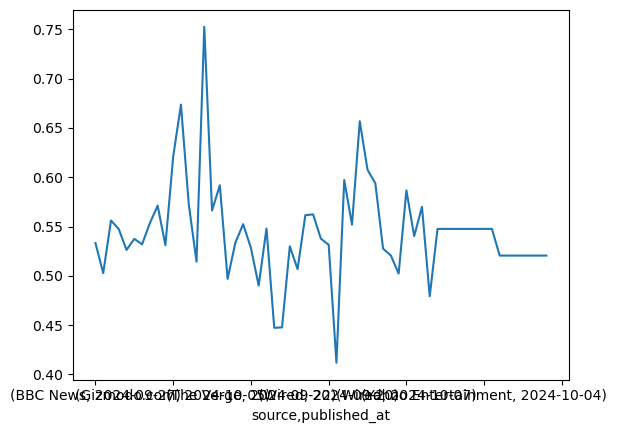

In [46]:
result.plot()

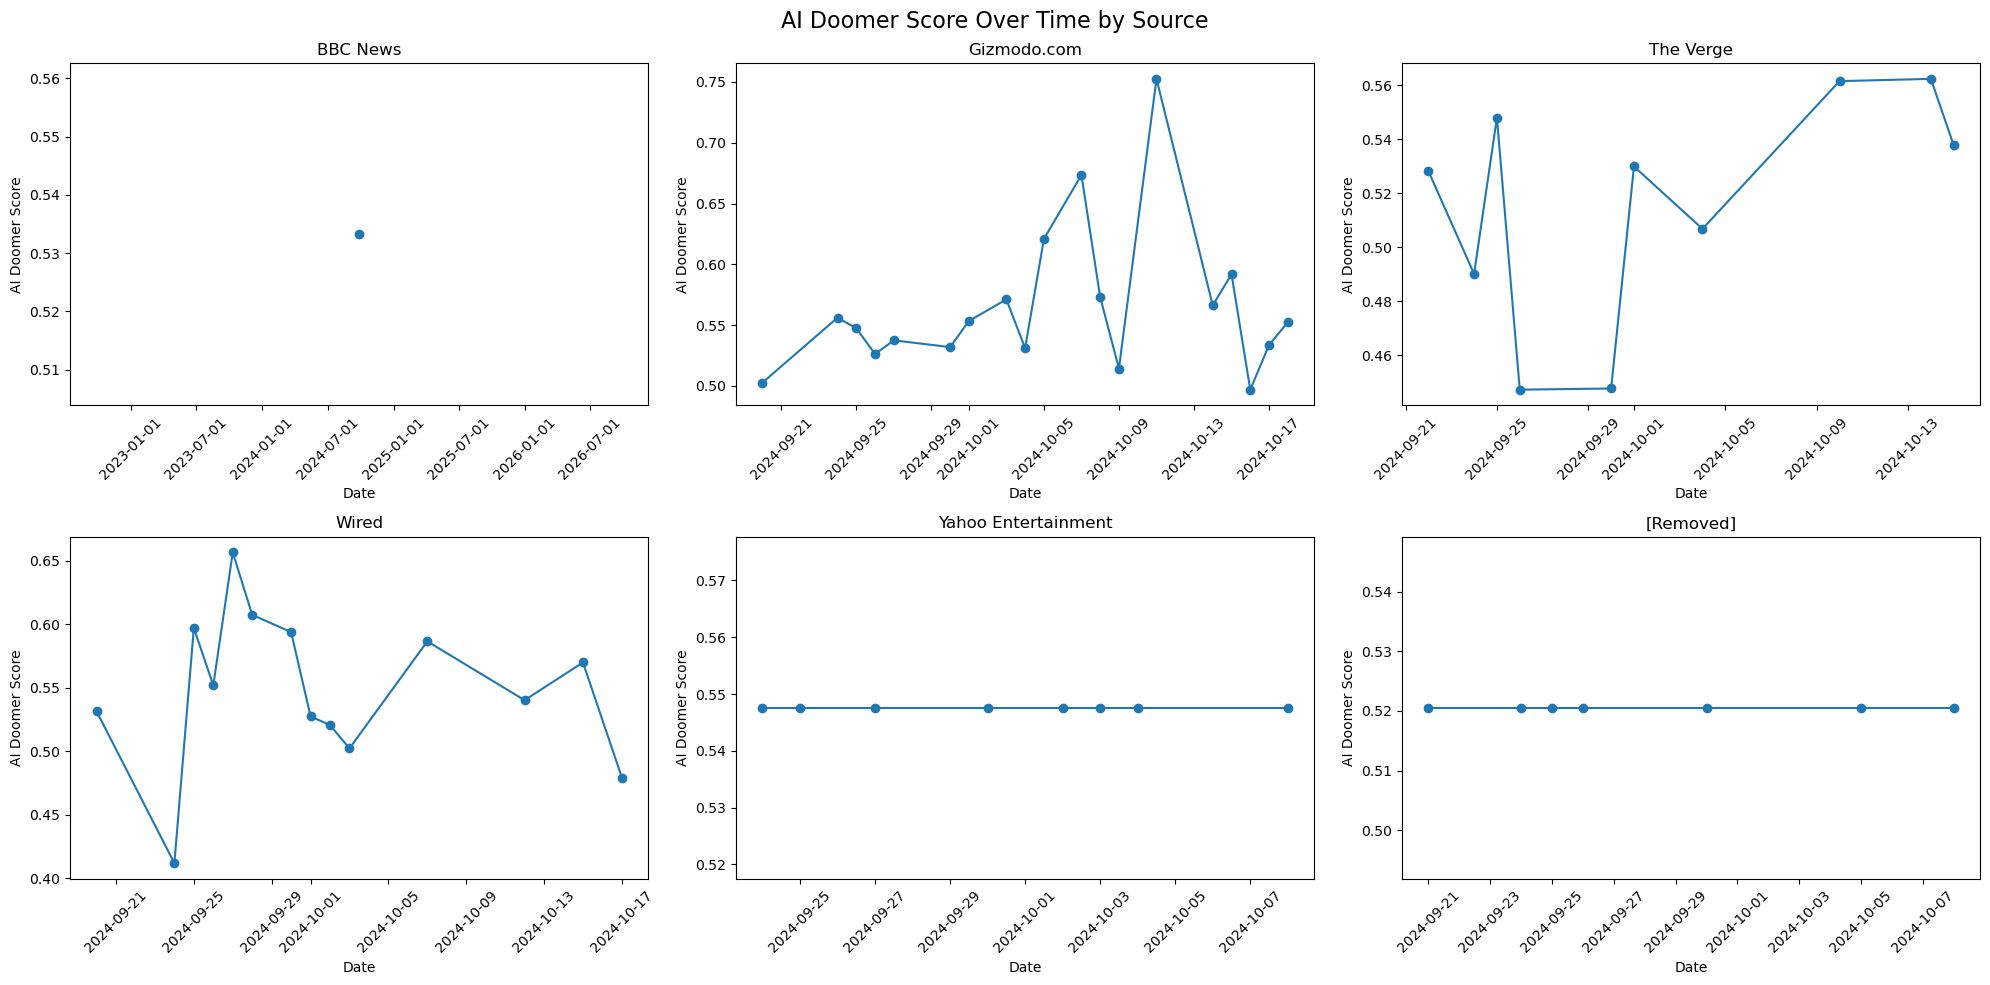

In [48]:
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
import numpy as np

# Reset the index to make 'source' and 'date' columns
result = result.reset_index()

# Get unique sources
sources = result['source'].unique()

# Calculate the number of rows and columns for subplots
n = len(sources)
cols = 3
rows = (n + cols - 1) // cols

# Create subplots
fig, axes = plt.subplots(rows, cols, figsize=(20, 5*rows), squeeze=False)
fig.suptitle('AI Doomer Score Over Time by Source', fontsize=16)

# Flatten the axes array for easier iteration
axes = axes.flatten()

for i, source in enumerate(sources):
    source_data = result[result['source'] == source]
    
    ax = axes[i]
    ax.plot(source_data['published_at'], source_data['score_v2'], marker='o')
    ax.set_title(source)
    ax.set_xlabel('Date')
    ax.set_ylabel('AI Doomer Score')
    ax.tick_params(axis='x', rotation=45)
    ax.xaxis.set_major_formatter(DateFormatter('%Y-%m-%d'))

# Remove any unused subplots
for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

In [54]:
df.columns

Index(['source', 'author', 'title', 'description', 'url', 'published_at',
       'content', 'stance', 'score', 'score_v2'],
      dtype='object')